In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import xgboost as xgb
import multiprocessing
import difflib
from nltk.corpus import stopwords
from nltk.metrics import jaccard_distance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

test.csv
train.csv



In [2]:
df_train = pd.read_csv("../input/train.csv").fillna("")
df_test = pd.read_csv("../input/test.csv").fillna("")

In [3]:
stops = set(stopwords.words("english"))

In [4]:
def build_dict(sentences):
#    from collections import OrderedDict

    '''
    Build dictionary of train words
    Outputs: 
     - Dictionary of word --> word index
     - Dictionary of word --> word count freq
    '''
    print('Building dictionary..'),
    wordcount = dict()
    #For each worn in each sentence, cummulate frequency
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1
    
    worddict = dict()
    for idx, w in enumerate(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)):
        worddict[w[0]] = idx+2  # leave 0 and 1 (UNK)

    return worddict, wordcount

In [5]:
def generate_sequence(sentences, dictionary):
    '''
    Convert tokenized text in sequences of integers
    '''
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]

    return seqs

In [6]:
def normalize(x):
    return x.lower().split()

In [7]:
questions = df_train['question1'].tolist() + df_train['question2'].tolist()

In [8]:
tok_questions = [normalize(s) for s in questions]
worddict, wordcount = build_dict(tok_questions)

Building dictionary..


In [9]:
print(np.sum(list(wordcount.values())), ' total words ', len(worddict), ' unique words')

8944591  total words  201102  unique words


In [10]:
def jc(x):
    return jaccard_distance(set(x['s_question1']),set(x['s_question2']))

In [11]:
def cosine_d(x):
    a = set(x['s_question1'])
    b = set(x['s_question2'])
    d = len(a)*len(b)
    if (d == 0):
        return 0
    else: 
        return len(a.intersection(b))/d

In [12]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf.fit_transform(questions)

<808580x85847 sparse matrix of type '<class 'numpy.float64'>'
	with 4075659 stored elements in Compressed Sparse Row format>

In [13]:
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.quick_ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [14]:
def get_features(df_features):
    
    print('jaccard...')
    df_features['s_question1'] = generate_sequence(df_features['question1'].apply(normalize),worddict)
    df_features['s_question2'] = generate_sequence(df_features['question2'].apply(normalize),worddict)
    df_features['z_jaccard'] = df_features.apply(jc,axis = 1)
    
    print('cosine....')
    df_features['z_cosine'] = df_features.apply(cosine_d,axis = 1)
    
    print('length....')
    df_features['z_len1'] = df_features.question1.map(lambda x: len(str(x)))
    df_features['z_len2'] = df_features.question2.map(lambda x: len(str(x)))
    df_features['z_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    df_features['z_word_len2'] = df_features.question2.map(lambda x: len(str(x).split())) 
    
    print('difflib...')
    df_features['z_match_ratio'] = df_features.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    
    print('word match...')
    df_features['z_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    
    print('tfidf...')
    question1_tfidf = tfidf.transform(df_features.question1.tolist())
    question2_tfidf = tfidf.transform(df_features.question2.tolist())
    df_features['z_tfidf_sum1'] = np.sum(question1_tfidf, axis = 1)
    df_features['z_tfidf_sum2'] = np.sum(question2_tfidf, axis = 1)
    df_features['z_tfidf_mean1'] = np.mean(question1_tfidf, axis = 1)
    df_features['z_tfidf_mean2'] = np.mean(question2_tfidf, axis = 1)
    df_features['z_tfidf_len1'] = (question1_tfidf != 0).sum(axis = 1)
    df_features['z_tfidf_len2'] = (question2_tfidf != 0).sum(axis = 1)
    
    return df_features.fillna(0.0)

In [15]:
df_train = get_features(df_train)

jaccard...
cosine....
length....
difflib...
word match...
tfidf...


In [16]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,s_question1,s_question2,z_jaccard,z_cosine,...,z_word_len1,z_word_len2,z_match_ratio,z_word_match,z_tfidf_sum1,z_tfidf_sum2,z_tfidf_mean1,z_tfidf_mean2,z_tfidf_len1,z_tfidf_len2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[3, 4, 2, 1394, 55, 1394, 2940, 8, 519, 9, 748...","[3, 4, 2, 1394, 55, 1394, 2940, 8, 519, 9, 748...",0.230769,0.075758,...,14,12,0.926829,0.727273,2.240002,2.088038,0.000026,0.000024,6,5
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[3, 4, 2, 749, 10, 18336, 37977, 13264]","[3, 42, 174, 24, 2, 82, 242, 13821, 2, 18336, ...",0.750000,0.041667,...,8,13,0.705036,0.307692,2.201585,2.716808,0.000026,0.000032,5,8
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[5, 14, 6, 179, 2, 467, 10, 18, 522, 2556, 166...","[5, 14, 522, 467, 26, 4253, 55, 2125, 181, 37684]",0.800000,0.028571,...,14,10,0.772727,0.363636,2.419526,2.198229,0.000028,0.000026,6,5
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[17, 67, 6, 3010, 254, 5384, 5, 14, 6, 546, 113]","[80, 2, 4564, 37, 151370, 4, 2517, 55, 151371]",1.000000,0.000000,...,11,9,0.573913,0.000000,1.724631,2.165024,0.000020,0.000025,3,5
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[23, 50, 8304, 9, 276, 56358, 32069, 34647, 19...","[23, 2371, 42, 1359, 9, 2317, 811]",0.888889,0.021978,...,13,7,0.626087,0.000000,2.947620,1.986790,0.000034,0.000023,9,4


In [17]:
col = [c for c in df_train.columns if c[:1]=='z']

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train[col], df_train['is_duplicate'], test_size=0.2, random_state=0)

In [19]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1632

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, 
                early_stopping_rounds=50, 
                verbose_eval=100) #change to higher #s

[0]	train-logloss:0.686018	valid-logloss:0.686032
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.473475	valid-logloss:0.47404
[200]	train-logloss:0.447331	valid-logloss:0.448135
[300]	train-logloss:0.440429	valid-logloss:0.441342
[400]	train-logloss:0.436194	valid-logloss:0.437216
[499]	train-logloss:0.432856	valid-logloss:0.434128


In [20]:
print(log_loss(df_train.is_duplicate, bst.predict(xgb.DMatrix(df_train[col]))))

0.433110204009


In [21]:
df_test = get_features(df_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(df_test[col]))

jaccard...
cosine....
length....
difflib...
word match...
tfidf...


In [22]:
sub.to_csv('zmix_submission_xgb_01.csv', index=False)

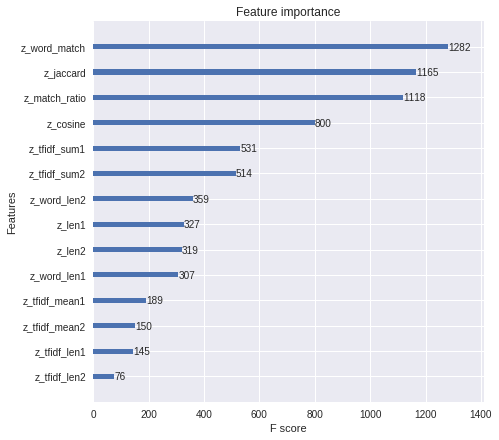

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(bst); plt.show()